In [2]:
# -*- coding: utf-8 -*-
"""
Created on Fri Nov 29 10:33:38 2019

@author: ma3352bo
"""

from brian2 import *

# Some Brian2 commands to set up the compiler properly
start_scope() 
prefs.codegen.target = 'numpy'  # use the Python fallback
set_device('runtime', build_on_run=False)

###  Equations for the synapses - STDP 

In [3]:
# STDP equations
Apre = Apost = 0.03
wmax = 1.0
tau_pre = 20*ms
tau_post = 35*ms #depression decays slower
stdp_eq = '''
    w : 1
    dapre/dt = -apre/tau_pre : 1 (event-driven)
    dapost/dt = -apost/tau_post : 1 (event-driven)
    '''
on_pre_eq = '''
    v_post += w
    apre += Apre
    w = clip(w-apost, 0, wmax)
    '''
on_post_eq =  '''
    apost += Apost
    w = clip(w+apre,0, wmax)
    '''

### The neuron model - differential equations

In [4]:
    
#Neuron differential equations

tau_v = 20*ms #20ms
T = 1.0

# neuron model
eqs = '''
dv/dt = -v/tau_v : 1
'''
thres = 'v > T'
res = '''
v=0
'''

### Construct the network

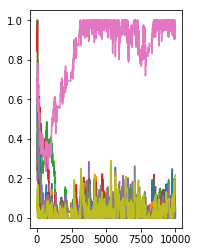

In [5]:
#INPUT LAYER
num_inputs = 10
input_rate = 50*Hz
P = PoissonGroup(num_inputs, rates=input_rate)

#SINGLE POSTNEURON
G = NeuronGroup(1, eqs, threshold=thres, reset=res, method='exact')

#SYNAPSES
S = Synapses(P, G, stdp_eq, on_pre=on_pre_eq, on_post=on_post_eq)
S.connect()
S.w = 'rand()*wmax' #random initial weight assignment

#MONITORS
M = PopulationRateMonitor(G)
WM = StateMonitor(S,'w', record=True)

#RUN SIMULATION AND PLOT RESULT
run(10*second)
for i in range(1, num_inputs):
    subplot(1,2,1)
    plot(WM.t/ms, WM[S[i]].w)

Text(0,0.5,'Postneuron activity (hz)')

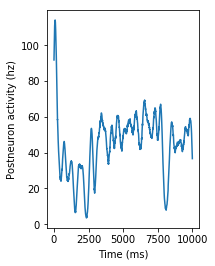

In [6]:
xlabel('Time (ms)')
ylabel('Synapse weight')

subplot(1,2,2)
plot(M.t/ms, M.smooth_rate(width=100*ms)/Hz)
xlabel('Time (ms)')
ylabel('Postneuron activity (hz)')

#plot(M.t/ms, M.rate/Hz)
#xlabel('Time (ms)')
#ylabel('Postneuron activity')

#store() #store network state
#for tau in tau_range:
#    restore()
#    # Run it and store the output firing rate in the list
#    run(1*second)
#    output_rates.append(M.num_spikes/second)
#    print('hej')
# And plot it
#plot(tau_range/ms, output_rates)
#xlabel(r'$\tau$ (ms)')
#ylabel('Firing rate (sp/s)');